In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from datetime import datetime

/Users/thomas/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv(r"/Users/thomas/ensae-prog2A/ensae-prog2A/ensae-prog2A/df_final.csv")
data.shape

/var/folders/vt/6c09fl4n7h7dmmfb0j2ctpf40000gn/T/ipykernel_47087/3376985063.py:1: DtypeWarning: Columns (1,19,20,21,22,34,39,40,41,42,43,49,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"/Users/thomas/ensae-prog2A/ensae-prog2A/ensae-prog2A/df_final.csv")


(5017137, 54)

### Analyse de la forme des données

In [4]:
df = data.copy()

<Axes: ylabel='count'>

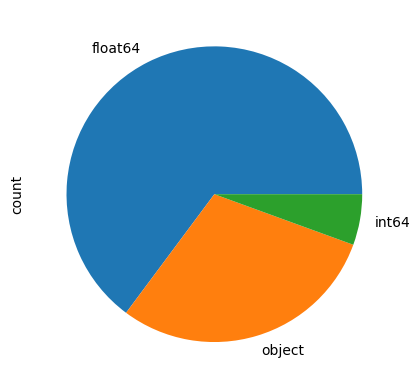

In [5]:
df.dtypes.value_counts().plot.pie()

Le camembert ci-dessus montre les différents types de variables présents dans la base de données. Nous déduisons de ces types que nous avons à la fois des variables qualitatives et des variables quantitatives.

#### Données manquantes

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

KeyboardInterrupt: 

<Figure size 2000x1000 with 0 Axes>

Sur cette heatmap, on a en noir les valeurs bien présentes et en beige les valeurs NaN manquantes. On remarque que certains colonnes semblent ne contenir que des NaN. 
Regardons plus en détail le taux de valeurs manquantes par colonnes.
 

In [7]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

index                                              0.000000
code_commune_INSEE                                 0.000000
lat                                                0.000000
lon                                                0.000000
region                                             0.000000
number_sta                                         0.000000
date                                               0.000000
lat_sta                                            0.000000
lon_sta                                            0.000000
height_sta                                         0.000000
incendie                                           0.000000
t                                                  0.038089
hu                                                 0.242230
td                                                 0.242340
precip                                             0.332814
ff                                                 0.585039
dd                                      

Toutes les colonnes provenant de la base de données incendie ne sont en fait remplies que lorsqu'il y a un incendie (elle ne sont pas présentes dans la base météo France). En vue de la modélisation et de la recherche des variables météo influençant le risque d'incendie, elles sont donc inexploitables.

## Analyse du Fond
### 1. Visulation initiale - Elimination des colonnes inutiles

On peut à présent nettoyer la base en excluant les variables pour lesquelles on ne dispose de presque aucune valeur (i.e celles pour lesquelles le taux de valeurs manquantes Nan est supérieur à 99%). Cela supprime les variables de la base incendies et conserve les variables météorologiques bien que certaines grandeurs comme la pression (psl) ont beaucoup de valeurs manquantes (plus de 90%).

In [5]:
df = df[df.columns[df.isna().sum()/df.shape[0] <0.99]]
df.head()
df.shape

(5017137, 18)

Nous affichons désormais la nouvelle heatmap des NaN de cette base de données épurée.

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

Le data frame est quasiment prêt. Puisqu'on a associé chaque incendie à une commune et aux données météorologiques moyennes du jour d'apparition de l'incendie, il n'est plus nécessaire de garder les coordonnées géographiques, le numéro de la station, l'index.

In [ ]:
df=df.drop(['index','lat','lon','lat_sta','lon_sta','height_sta', 'number_sta'], axis=1)
display(df.head())

### Examen de la colonne incendie
Peu de jours avec incendie, la métrique d'évaluation du modèle devra en prendre compte

In [9]:
df['incendie'].value_counts(normalize=True)

incendie
0    0.999713
1    0.000287
Name: proportion, dtype: float64

In [15]:
df['incendie'].sum()

1442

### Graphiques des variables continues 

#### Tout d'abord, convertissons les températures en delgré Celsius

In [6]:
df['t']=df['t']-273.15
df['td']=df['td']-273.15

#### distribution des variables météorologiques 

/var/folders/vt/6c09fl4n7h7dmmfb0j2ctpf40000gn/T/ipykernel_47087/707928491.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['dd'])


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

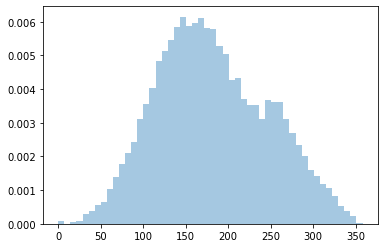

In [7]:
"distribution de dd"
plt.figure()
sns.distplot(df['dd'])
plt.show()

La direction du vent (en degrés) a une distribution continue, elle semble un peu étalée à droite.

/var/folders/vt/6c09fl4n7h7dmmfb0j2ctpf40000gn/T/ipykernel_47087/1355553827.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['ff'])


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

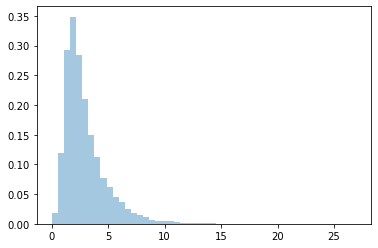

In [8]:
"distribution de ff"
plt.figure()
sns.distplot(df['ff'])
plt.show()

La force du vent en (m/s) a également une distribution continue, positive et étalée à droite. Elle ressemble à une distribution de loi Gamma pour certains paramètres.

In [ ]:
"distribution de t"
plt.figure()
sns.distplot(df['t'])
plt.show()

In [ ]:
"distribution de td"
plt.figure()
sns.distplot(df['td'])
plt.show()

Les températures moyenne sur la journée (t) et de rosée (td) sont exprimées en degrés celsius et ont une distribution continue n'ayant pas la forme d'une distribution classique. Elles ont plusieurs pics de densité, ce qui fait penser à un modèle de mélange (où les plusieurs populations seraient les différentes saisons).

In [ ]:
"distribution de psl"
plt.figure()
sns.distplot(df['psl'])
plt.show()

La pression (en pascal) est continue, et a une forme de distribution gaussienne. C'est la variable qui semble le plus être distribuée normalement.

In [ ]:
"distribution de precip"
plt.figure()
sns.distplot(df['precip'])
plt.show()

la précipitation (en kg.m^2) n'est ni continue, ni discrète. Il met de la masse sur 0 (il y a une part significative des jours où il ne pleut pas) et est ensuite diffuse sur les valeurs strictement positive.

In [ ]:
"distribution de hu"
plt.figure()
sns.distplot(df['hu'])
plt.show()

L'humidité (en "pourcentage %") est continue, ne ressemble pas à une distribution connue. On observe deux pics principaux, ce qui fait penser à un modèle de mélange comme pour la température.

### Variables Qualitatives

In [15]:
for col in df.select_dtypes('object'):
    print(f'{col :-<50} {df[col].unique()}')

code_commune_INSEE-------------------------------- [1001 1002 1004 ... 87204 87205 87206]
region-------------------------------------------- ['Auvergne-Rhône-Alpes' "Provence-Alpes-Côte d'Azur" 'Occitanie'
 'Nouvelle-Aquitaine' 'Corse']
date---------------------------------------------- ['2018-12-05' '2018-12-14' '2018-12-15' '2018-12-16' '2018-12-17'
 '2018-12-18' '2018-12-19' '2018-12-20' '2018-12-21' '2018-12-22'
 '2018-12-23' '2018-12-24' '2018-12-25' '2018-12-26' '2018-12-27'
 '2018-12-28' '2018-12-29' '2018-12-30' '2018-12-31' '2018-01-01'
 '2018-01-02' '2018-01-03' '2018-01-04' '2018-01-05' '2018-01-06'
 '2018-01-07' '2018-01-08' '2018-01-09' '2018-01-10' '2018-01-11'
 '2018-01-12' '2018-01-13' '2018-01-14' '2018-01-15' '2018-01-16'
 '2018-01-17' '2018-01-18' '2018-01-19' '2018-01-20' '2018-01-21'
 '2018-01-22' '2018-01-23' '2018-01-24' '2018-01-25' '2018-01-26'
 '2018-01-27' '2018-01-28' '2018-01-29' '2018-01-30' '2018-01-31'
 '2018-02-01' '2018-02-02' '2018-02-03' '2018-02-04'

## Relation Target / Variables
### Création de sous-ensembles positifs et négatifs

In [46]:
incendie_df = df[df['incendie'] == 1]
no_incendie_df = df[df['incendie'] == 0]


### distributions des variables météorologiques pour les jours d'incendies et les jours sans incendies

Nous allons désormais tracer les distributions des variables météo conditionnellement à la valeur de la variable incendie. Ceci nous permettra d'observer s'il y a des différences moyennes entre le groupe des données d'incendie, et le groupe des données sans incendie

/tmp/ipykernel_21184/49771202.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(incendie_df[col], label='positive', color='orange')
/tmp/ipykernel_21184/49771202.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(no_incendie_df[col], label='negative', color='blue')
/tmp/ipykernel_21184/497712

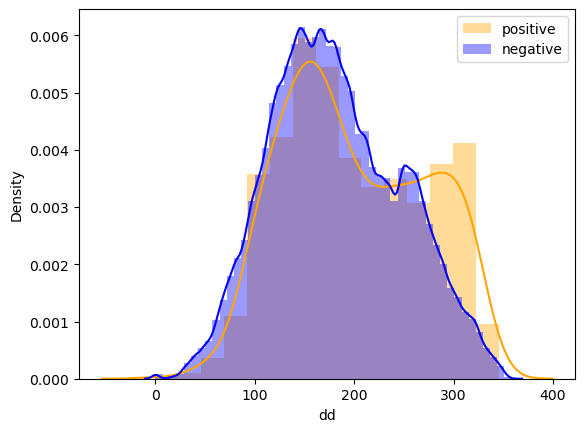

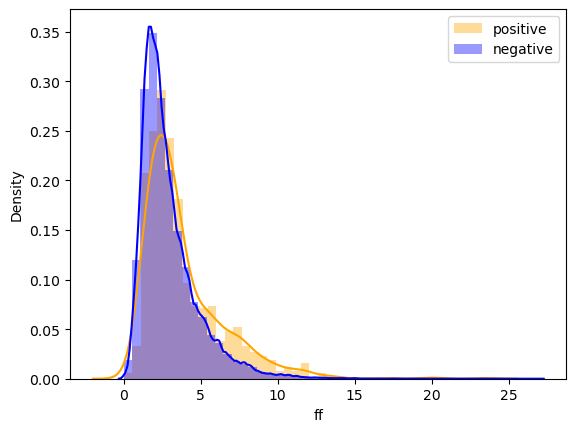

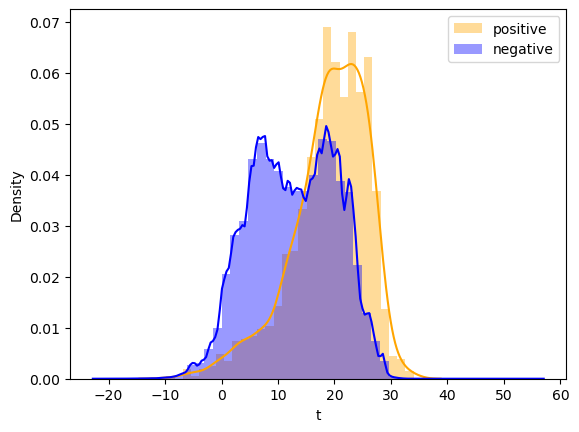

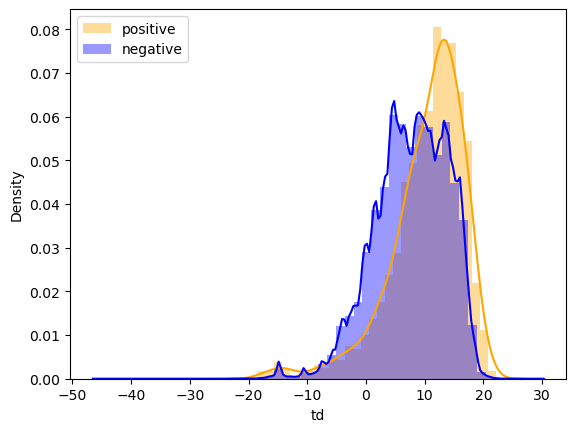

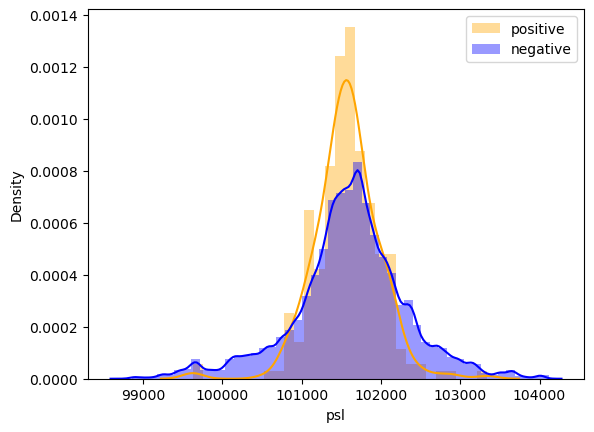

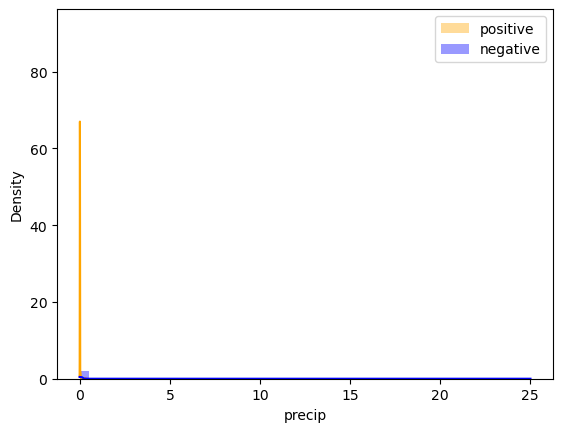

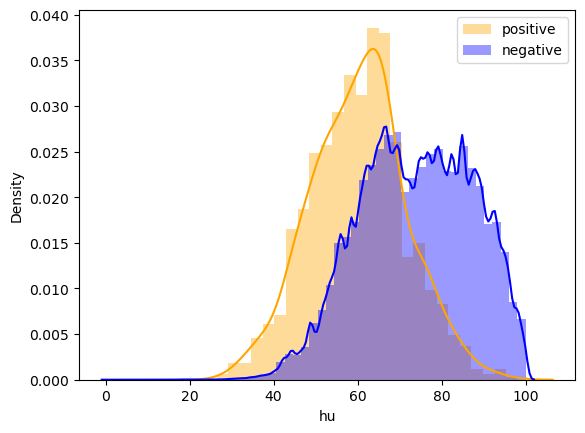

In [17]:
for col in ['dd','ff','t','td','psl','precip','hu']:
    plt.figure()
    sns.distplot(incendie_df[col], label='positive', color='orange')
    sns.distplot(no_incendie_df[col], label='negative', color='blue')
    plt.legend()

<div align="justify">
Lorsqu'on compare les distributions des deux groupes, il semblerait que les températures et les températures de rosée des jours d'incendie soient soient en moyenne plus élevées de celles des jours sans incendie. De même, l'humidité paraît en moyenne plus basse quand il y a un incendie.
La différence de distribution de la direction du vent n'est pas significative. La vitesse du vent quant à elle semble être très légèrement élevée lorsqu'il y a un incendie mais cela n'est pas clair.
On n'observe pas de différence moyenne pour la pression. La distribution semble cependant moins étalée lorsqu'il y a un incendie.
On voit qu'il n'y a systématiquement pas de pluie sur les jours d'incendie (precip=0).

Il faudra alors effectuer des tests pour vérifier si effectivement les distributions des variables météorologiques sont différentes pour les deux groupes.

## T-Test

In [64]:
from scipy.stats import ttest_ind

In [65]:
balanced_neg = no_incendie_df.sample(incendie_df.shape[0])

In [66]:
for col in ['dd','ff','t','td','psl','precip','hu']:
    stat, p = ttest_ind(balanced_neg[col].dropna(), incendie_df[col].dropna())

    print(col,p)

dd 1.432390662631065e-07
ff 1.0575956045806356e-12
t 5.589024813884139e-108
td 9.490119952665402e-23
psl 0.8412951115064559
precip 0.16937141706666373
hu 1.5081885307955212e-123


La variable précipitation n'est pas distribuée normalement (même conditionellement à l'incendie) donc les hypothèses du t-test ne sont pas vérifiées. La normalité des autres variables est également discutable, nous allons alors faire un test non paramétrique: celui de Mann Whitney.

## test de Mann Whitney

In [76]:
from scipy.stats import mannwhitneyu

In [77]:
for col in ['dd','ff','t','td','psl','precip','hu']:
    stat, p = mannwhitneyu(balanced_neg[col].dropna(), incendie_df[col].dropna())
    print(col,p)

dd 2.567262354706836e-06
ff 1.1305774950255587e-12
t 2.7810696925819686e-104
td 1.7163073727334056e-30
psl 0.160747155299506
precip 1.4419775898673226e-40
hu 3.879156400565424e-108


 On trouve les mêmes significativité de la différence moyenne/médiane des variables météorologiques selon qu'il y ait un incendie ou non. Cependant pour la précipitation, le test de Mann Whitney trouve une différence médiane significative qui n'était pas trouvée par le t-test. Le test de Mann Whitney est plus robuste compte tenu des hypothèses de normalité qui ne sont pas respectées. Un autre test est celui de la corrélation de Pearson qui étudie si la corrélation entre la variable incendie et la variable météorologique est significativement différente de 0, à noter que lorsqu'une des deux variables est binaire on appelle cette corrélation la corrélation du point bisériel.

## test de corrélation Pearson

In [80]:
from scipy.stats import pearsonr

# Calcul de la corrélation de point bisériel
for col in ['dd','ff','t','td','psl','precip','hu']:
    dfcol=df[[col,'incendie']].dropna()
    corr, p_value = pearsonr(dfcol[col], dfcol['incendie'])
    print(col)
    print('Coefficient de corrélation de point bisériel:', corr)
    print('P-value:', p_value)


dd
Coefficient de corrélation de point bisériel: 0.006095784140236081
P-value: 1.4256413743288278e-18
ff
Coefficient de corrélation de point bisériel: 0.010427608785240284
P-value: 3.6540255244087337e-51
t
Coefficient de corrélation de point bisériel: 0.014264388850828452
P-value: 1.4196961484219634e-215
td
Coefficient de corrélation de point bisériel: 0.007871010464071395
P-value: 3.7525651740625535e-53
psl
Coefficient de corrélation de point bisériel: -0.0010460780719684089
P-value: 0.48888767481110557
precip
Coefficient de corrélation de point bisériel: -0.0012602480688508185
P-value: 0.02112596082994058
hu
Coefficient de corrélation de point bisériel: -0.01813874167470398
P-value: 4.876781496295125e-274


### corrélations entre variables météorologiques

In [9]:
df[['dd','ff','t','td','psl','precip','hu']].corr()


,dd,ff,t,td,psl,precip,hu
dd,1.000000,0.312515,-0.025769,-0.043705,0.042849,-0.008629,-0.029410
ff,0.312515,1.000000,-0.101074,-0.155301,-0.167057,0.072756,-0.097582
t,-0.025769,-0.101074,1.000000,0.909360,0.005940,-0.037033,-0.547697
td,-0.043705,-0.155301,0.909360,1.000000,0.025117,-0.000568,-0.157271
psl,0.042849,-0.167057,0.005940,0.025117,1.000000,-0.212960,0.062692
precip,-0.008629,0.072756,-0.037033,-0.000568,-0.212960,1.000000,0.080158
hu,-0.029410,-0.097582,-0.547697,-0.157271,0.062692,0.080158,1.000000


<div align="justify">
La table des corrélations entre les variables météorologiques est intéressante à étudier en vu notamment de la modélisation.
En effet, nous comptons prédire le risque d'incendie avec une régression logistique et interpréter les coefficients. L'interprétation des coefficients doit être nuancée par la prise en compte des corrélations entre les variables explicatives.
Ici, la température moyenne sur la journée (t) et la température de rosée (td) sont très fortement positivement corrélées (à plus de 90%). Cette corrélation sera à prendre en compte lors de l'interprétation des coefficients associés à t et td.